# Deep Bayesian

## Section 0

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from numpy import pi, cos, sin, exp, sqrt
from scipy.integrate import *
import scipy.signal, scipy.interpolate
from scipy.optimize import minimize_scalar
import statistics

from tqdm import tqdm

In [5]:
# Parameters
alpha = 0.25
beta = 0.67
mu = 100e6
D = 11.5e3 ** 2 / 1e-6
T = 50e-6

In [6]:
def probcoin(t, r, f):
    return .5*(1+r*(alpha + beta*cos(2*pi*f*t)))

def prob(t, r, mu, sd):
    return .5*(1+r*alpha+r*beta*cos(2*pi*mu*t)*exp(-2*(pi*t*sd)**2))

def likelihood(t, r, f, mu, sd):
    cp = 1/sqrt(2*pi*sd**2)*exp(-((f-mu)**2)/(2*sd**2))
    
    return cp * probcoin(t, r, f) / prob(t, r, mu, sd)

def est(t, r, mu, sd):
    def ll(t, r, f, mu, sd):
        res = -(f-mu)**2/(2*sd**2)
        res += np.log(probcoin(t, r, f))
        
        return res
    
    f = np.linspace(80e6, 120e6, 100000)
    
    return f[np.argmax(ll(t, r, f, mu, sd))]

def mean(t, r, mu, sd):
    num = .5*(1+r*alpha)*mu+\
          .5*r*beta*(mu*cos(2*pi*t*mu)+sd*sin(2*pi*t*mu))*exp(-2*(pi*t*sd)**2)
    
    return num/prob(t, r, mu, sd)

def var(t, r, mu, sd):
    v = sd**2
    
    num = .5*v*(1+r*alpha)-\
          .5*r*beta*v*cos(2*pi*t*mu)*((2*pi*t*sd)**2-1)*exp(-2*(pi*t*sd)**2)
    
    return num/prob(t, r, mu, sd)

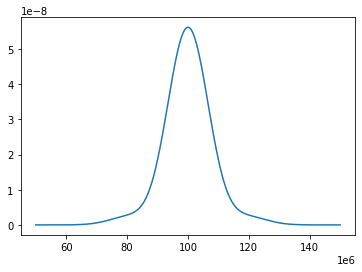

In [7]:
f = np.linspace(50e6, 150e6, 1000)
t = 30e-9
mu = 100e6
sd = 10e6
lk = likelihood(t, 1, f, mu, sd)

plt.plot(f, lk)
plt.ticklabel_format(axis='x', scilimits=(6, 6))
plt.show()

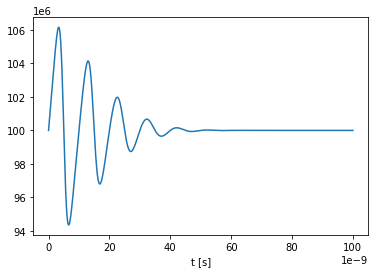

In [8]:
t = np.linspace(0, 100e-9, 10000)    

plt.plot(t, mean(t, 1, mu, sd))
plt.xlabel('t [s]')
plt.xticks()
plt.ticklabel_format(axis='x', scilimits=(-9, -9))
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

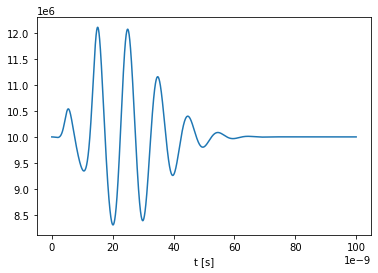

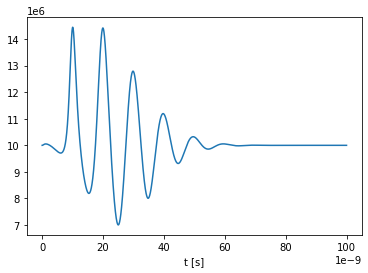

In [9]:
plt.plot(t, sqrt(var(t, 1, mu, sd)))
plt.xlabel('t [s]')
plt.ticklabel_format(axis='x', scilimits=(-9, -9))
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

plt.plot(t, sqrt(var(t, -1, mu, sd)))
plt.xlabel('t [s]')
plt.ticklabel_format(axis='x', scilimits=(-9, -9))
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

# Section 1

The function $\mathrm{asym}(t;\alpha, \beta)$ assumes that $\cos(2\pi\mu t)=-1$ and $\mu$ is large enough.

Minimum of $\mathrm{asym}(t;\alpha, \beta)$ is at $t=\frac{0.86038}{\pi\sigma}$ and the value is $0.76414\sigma^2$. ($\alpha=0.25$ and $\beta=0.67$)

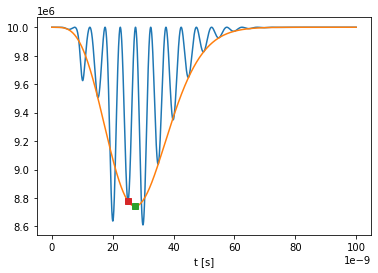

In [10]:
def lower_envelope(lst):
    x = []
    y = []
    for i, data in enumerate(lst):
        if 0 < i < len(lst)-1:
            if lst[i-1] > data and lst[i+1] > data:
                x.append(i)
                y.append(data)

    func_y = scipy.interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')

    envelope = []
    for i in range(len(lst)):
         envelope.append(func_y(i))

    return envelope

t = np.linspace(0, 100e-9, 10000)    
mu = 100e6
sd = 10e6
# mean_var = sum([prob(t, r, mu, sd) * var(t, r, mu, sd) for r in [-1, 1]])
mean_var = sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])
plt.plot(t, sqrt(mean_var))

# plt.plot(t, lower_envelope(sqrt(mean_var)))
asym1 = sd**2 * (1 - (2*pi*t*sd)**2*beta**2*(1 - exp(-2*(pi*t*sd)**2))*exp(-2*(pi*t*sd)**2)/(1-(alpha-beta*exp(-2*(pi*t*sd)**2))**2))
plt.plot(t, sqrt(asym1))

plt.plot(0.86038/pi/sd, sqrt(0.7641*sd**2), 's')
k = round(mu/sd/pi*0.86038-.5)
t = (k+.5)/mu
plt.plot(t, sqrt(sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])), 's')

plt.xlabel('t [s]')
plt.ticklabel_format(axis='x', scilimits=(-9, -9))
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

In [314]:
f0 = 104e6
alpha = 0
beta = 1

def toss(t):
    p = .5*(1 + alpha + beta * cos(2 * pi * t * f0))
    return np.random.choice([1, -1], p=[p, 1-p])

mu = 100e6
sd = 10e6
mul = []
tl = []
sdl = []
rl = []
N = 100
for i in range(N):
    k = round(mu/sd/pi*0.86038-.5)
    t = (k+.5)/mu
    #t = 1.01**i * 1e-7
    #t = 1e-9*i
    r = toss(t)

    tl.append(t)
    mul.append(mu)
    sdl.append(sd)
    rl.append(r)

    def mle(x):
        res = 1
        for r,t in zip(rl, tl):
            res *= 1+r*(alpha+beta*cos(2*pi*x*t))
        return res

    #f = np.linspace(mu-3*sd, mu+3*sd, 10000)
    f = np.linspace(80e6, 120e6, 10000)
    lk = mle(f)

    sd, mu = sqrt(sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])), f[np.argmax(lk)]
    # sd, mu = sqrt(sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])), mean(t, r, mu, sd)
    # sd = sqrt(sd**2 + 0.1e6**2)
    # sd, mu = sqrt(var(t, r, mu, sd)), est(t, r, mu, sd)
    # sd, mu = sqrt(var(t, r, mu, sd)), f[np.argmax(lk)]
        
print(f"Paper: {mu/1e6}")
print(f"Var: {sd/1e6}")

# def mle(x):
#     res = 0
#     for r,t in zip(rl, tl):
#         res += np.log(1+r*(alpha+beta*cos(2*pi*x*t)))
#     return res

# f = np.linspace(80e6, 120e6, 10000)
# lk = mle(f)

# plt.plot(f, lk)
# plt.ticklabel_format(axis='x', scilimits=(6, 6))
# plt.show()

# print(f[np.argmax(lk)]*1e-6)
    
# plt.plot(range(N), mul)
# plt.ticklabel_format(axis='y', scilimits=(6, 6))

# plt.show()
# plt.semilogy(range(N), sdl)
# plt.show()
# plt.semilogy(range(N), tl)
# plt.show()

Paper: 102.77427742774277
Var: 2.6154862821413792e-15


In [124]:
estl = []

for i in range(100):
    f0 = 103e6

    def toss(t):
        p = .5*(1 + alpha + beta * cos(2 * pi * t * f0))
        return np.random.choice([1, -1], p=[p, 1-p])

    mu = 100e6
    sd = 5e6
    mul = []
    tl = []
    sdl = []
    rl = []
    N = 100
    for i in range(N):
        k = round(mu/sd/pi*0.86038-.5)
        t = (k+.5)/mu
        # t = 1e-9 * i
        # t = 1.5**i * 1e-9
        # t = 1e-9*i
        r = toss(t)

        tl.append(t)
        mul.append(mu)
        sdl.append(sd)
        rl.append(r)

        def mle(x):
            res = 0
            for r,t in zip(rl, tl):
                res += np.log(1+r*(alpha+beta*cos(2*pi*x*t)))
            # res += -(x-mu)**2/2/sd**2
            return res

        #f = np.linspace(mu-3*sd, mu+3*sd, 10000)
        f = np.linspace(80e6, 120e6, 10000)
        lk = mle(f)

        sd, mu = sqrt(sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])), f[np.argmax(lk)]
        # sd, mu = sqrt(sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])), mean(t, r, mu, sd)
        # sd = sqrt(sd**2 + 0.1e6**2)
        # sd, mu = sqrt(var(t, r, mu, sd)), est(t, r, mu, sd)
        # sd, mu = sqrt(var(t, r, mu, sd)), f[np.argmax(lk)]
        
    estl.append(mu)

print(statistics.stdev(estl)/1e6)
print(statistics.mean(estl)/1e6)
plt.hist(estl)
plt.ticklabel_format(axis='x', scilimits=(6, 6))
plt.show()


estl = []

for i in range(100):
    f0 = 103e6

    def toss(t):
        p = .5*(1 + alpha + beta * cos(2 * pi * t * f0))
        return np.random.choice([1, -1], p=[p, 1-p])

    muml = []
    for j in range(3):
        mu = 102e6
        sd = 5e6
        mul = []
        tl = []
        sdl = []
        rl = []
        N = 15
        for i in range(N):
            k = round(mu/sd/pi*0.86038-.5)
            t = (k+.5)/mu
            # t = 1e-9 * i
            # t = 1.5**i * 1e-9
            # t = 1e-9*i
            r = toss(t)

            tl.append(t)
            mul.append(mu)
            sdl.append(sd)
            rl.append(r)

            def mle(x):
                res = 0
                for r,t in zip(rl, tl):
                    res += np.log(1+r*(alpha+beta*cos(2*pi*x*t)))
                # res += -(x-mu)**2/2/sd**2
                return res

            #f = np.linspace(mu-3*sd, mu+3*sd, 10000)
            f = np.linspace(80e6, 120e6, 10000)
            lk = mle(f)

            sd, mu = sqrt(sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])), f[np.argmax(lk)]
            # sd, mu = sqrt(sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])), mean(t, r, mu, sd)
            # sd = sqrt(sd**2 + 0.1e6**2)
            # sd, mu = sqrt(var(t, r, mu, sd)), est(t, r, mu, sd)
            # sd, mu = sqrt(var(t, r, mu, sd)), f[np.argmax(lk)]
            
        muml.append(mu)
        
    estl.append(statistics.median(muml))

print(statistics.stdev(estl)/1e6)
print(statistics.mean(estl)/1e6)
plt.hist(estl)
plt.ticklabel_format(axis='x', scilimits=(6, 6))
plt.show()

        
print(f"Paper: {mu/1e6}")
print(f"Var: {sd/1e6}")

def mle(x):
    res = 0
    for r,t in zip(rl, tl):
        res += np.log(1+r*(alpha+beta*cos(2*pi*x*t)))
    return res

f = np.linspace(80e6, 120e6, 10000)
lk = mle(f)

plt.plot(f, lk)
plt.ticklabel_format(axis='x', scilimits=(6, 6))
plt.show()

print(f[np.argmax(lk)]*1e-6)
    
plt.plot(range(N), mul)
plt.ticklabel_format(axis='y', scilimits=(6, 6))

plt.show()
plt.semilogy(range(N), sdl)
plt.show()
plt.semilogy(range(N), tl)
plt.show()

<ipython-input-124-8de7dab18aee>:33: RuntimeWarning: divide by zero encountered in log
  res += np.log(1+r*(alpha+beta*cos(2*pi*x*t)))


KeyboardInterrupt: 

In [9]:
f0 = 0.8

def toss(t):
    p = (sin(f0/2*t))**2
    return np.random.choice([1, -1], p=[p, 1-p])

mu = 0.5
sd = 0.5
mul = []
tl = []
sdl = []
rl = []
N = 200
for i in range(N):
    t = 1/sd
    k = round(mu/pi/sd + .5)
    r = toss(t)

    new_mu = mu - (pi * r * sd ** 2 * (-1)**k * (2*k-1) * exp(-(pi*sd*(1-2*k)/mu)**2/8))/2/mu
    new_sd = sqrt(sd**2 - ((pi*r*sd**2*(1-2*k))**2*exp(-(pi*sd*(1-2*k)/2/mu)**2)/4/mu**2))

    sd, mu = new_sd, new_mu
    # sd, mu = sqrt(sum([probcoin(t, r, mu) * var(t, r, mu, sd) for r in [-1, 1]])), mean(t, r, mu, sd)
    # sd = sqrt(sd**2 + 0.1e6**2)
    # sd, mu = sqrt(var(t, r, mu, sd)), est(t, r, mu, sd)
    # sd, mu = sqrt(var(t, r, mu, sd)), f[np.argmax(lk)]
        
print(f"AVg: {mu}")
print(f"Var: {sd}")

AVg: 0.8007137864140674
Var: 8.316395717264448e-21
